<a href="https://colab.research.google.com/github/sourcecode369/TensorFlow-2.0/blob/master/tensorflow_2.0_docs/TensorFlow%20Core/Tutorials/Images/Optimizing%20Models/Optimizing_Models_Performance_Shallow%2C_Deep%2C_Conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%time
from __future__ import print_function, division, unicode_literals, absolute_import

import os
os.environ["PYTHONHASHSEED"] = str(1)

import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
               rc={"lines.linewidth": 2.5})

from sklearn.model_selection import train_test_split

import warnings 
warnings.filterwarnings("ignore")

%reload_ext tensorboard
import time

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D

random.seed(1)
np.random.seed(1)

CPU times: user 1.54 s, sys: 168 ms, total: 1.7 s
Wall time: 1.95 s


In [2]:
#import util_mnist_reader
# X_train, y_train = util_mnist_reader.load_mnist("data/fashion/", kind='train')
# X_test, y_test = util_mnist_reader.load_mnist("data/fashion/", kind='t10k')


#comment down and uncomment above
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
X_train, X_test = X_train/255., X_test/255.

In [0]:
X_train, X_test = X_train.reshape(-1, 28*28), X_test.reshape(-1, 28*28)

In [0]:
labels = [ "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal",	"Shirt", "Sneaker", "Bag", "Ankle boot"]

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [0]:
def forward(X, W1, b1, W2, b2):
    Z = np.tanh(X.dot(W1) + b1)
    A = Z.dot(W2) + b2
    expA = np.exp(A)
    Y = expA / expA.sum(axis=1, keepdims=True)
    return Y, Z

def classification_rate(Y, P):
    n_correct = 0
    n_total = 0
    for i in range(len(Y)):
        n_total += 1
        if Y[i] == P[i]:
            n_correct += 1
    return float(n_correct) / n_total


def derivative_w2(Z, T, Y):
    N, K = T.shape
    M = Z.shape[1] 
    ret4 = Z.T.dot(T - Y)
    return ret4


def derivative_w1(X, Z, T, Y, W2):
    N, D = X.shape
    M, K = W2.shape
    dZ = (T - Y).dot(W2.T) * (1 - np.power(Z, 2))
    ret2 = X.T.dot(dZ)
    return ret2


def derivative_b2(T, Y):
    return (T - Y).sum(axis=0)


def derivative_b1(T, Y, W2, Z):
    return ((T - Y).dot(W2.T) * (1 - np.power(Z, 2))).sum(axis=0)


def cost(T, Y):
    m = T.shape[0]
    #tot = (T * np.log(Y) 
    tot= - (1/ m)*(np.multiply(T, np.log(Y)))
                             
    return np.sum(tot)

In [0]:
def vizualize_fmnist(X, y):
    X = X.reshape(-1,28,28)
    plt.figure(figsize=(20,18))    
    for e in range(36):
        plt.subplot(6, 6, e+1)
        idx = random.randint(0, len(y))
        plt.imshow(X[idx, :, :], cmap="gray", interpolation="nearest")
        plt.grid(True)
        plt.xticks([])
        plt.yticks([])
        plt.title(labels[y[idx]],fontsize=14)
    plt.suptitle("Fashion MNIST Dataset",fontsize=15)
    plt.show()

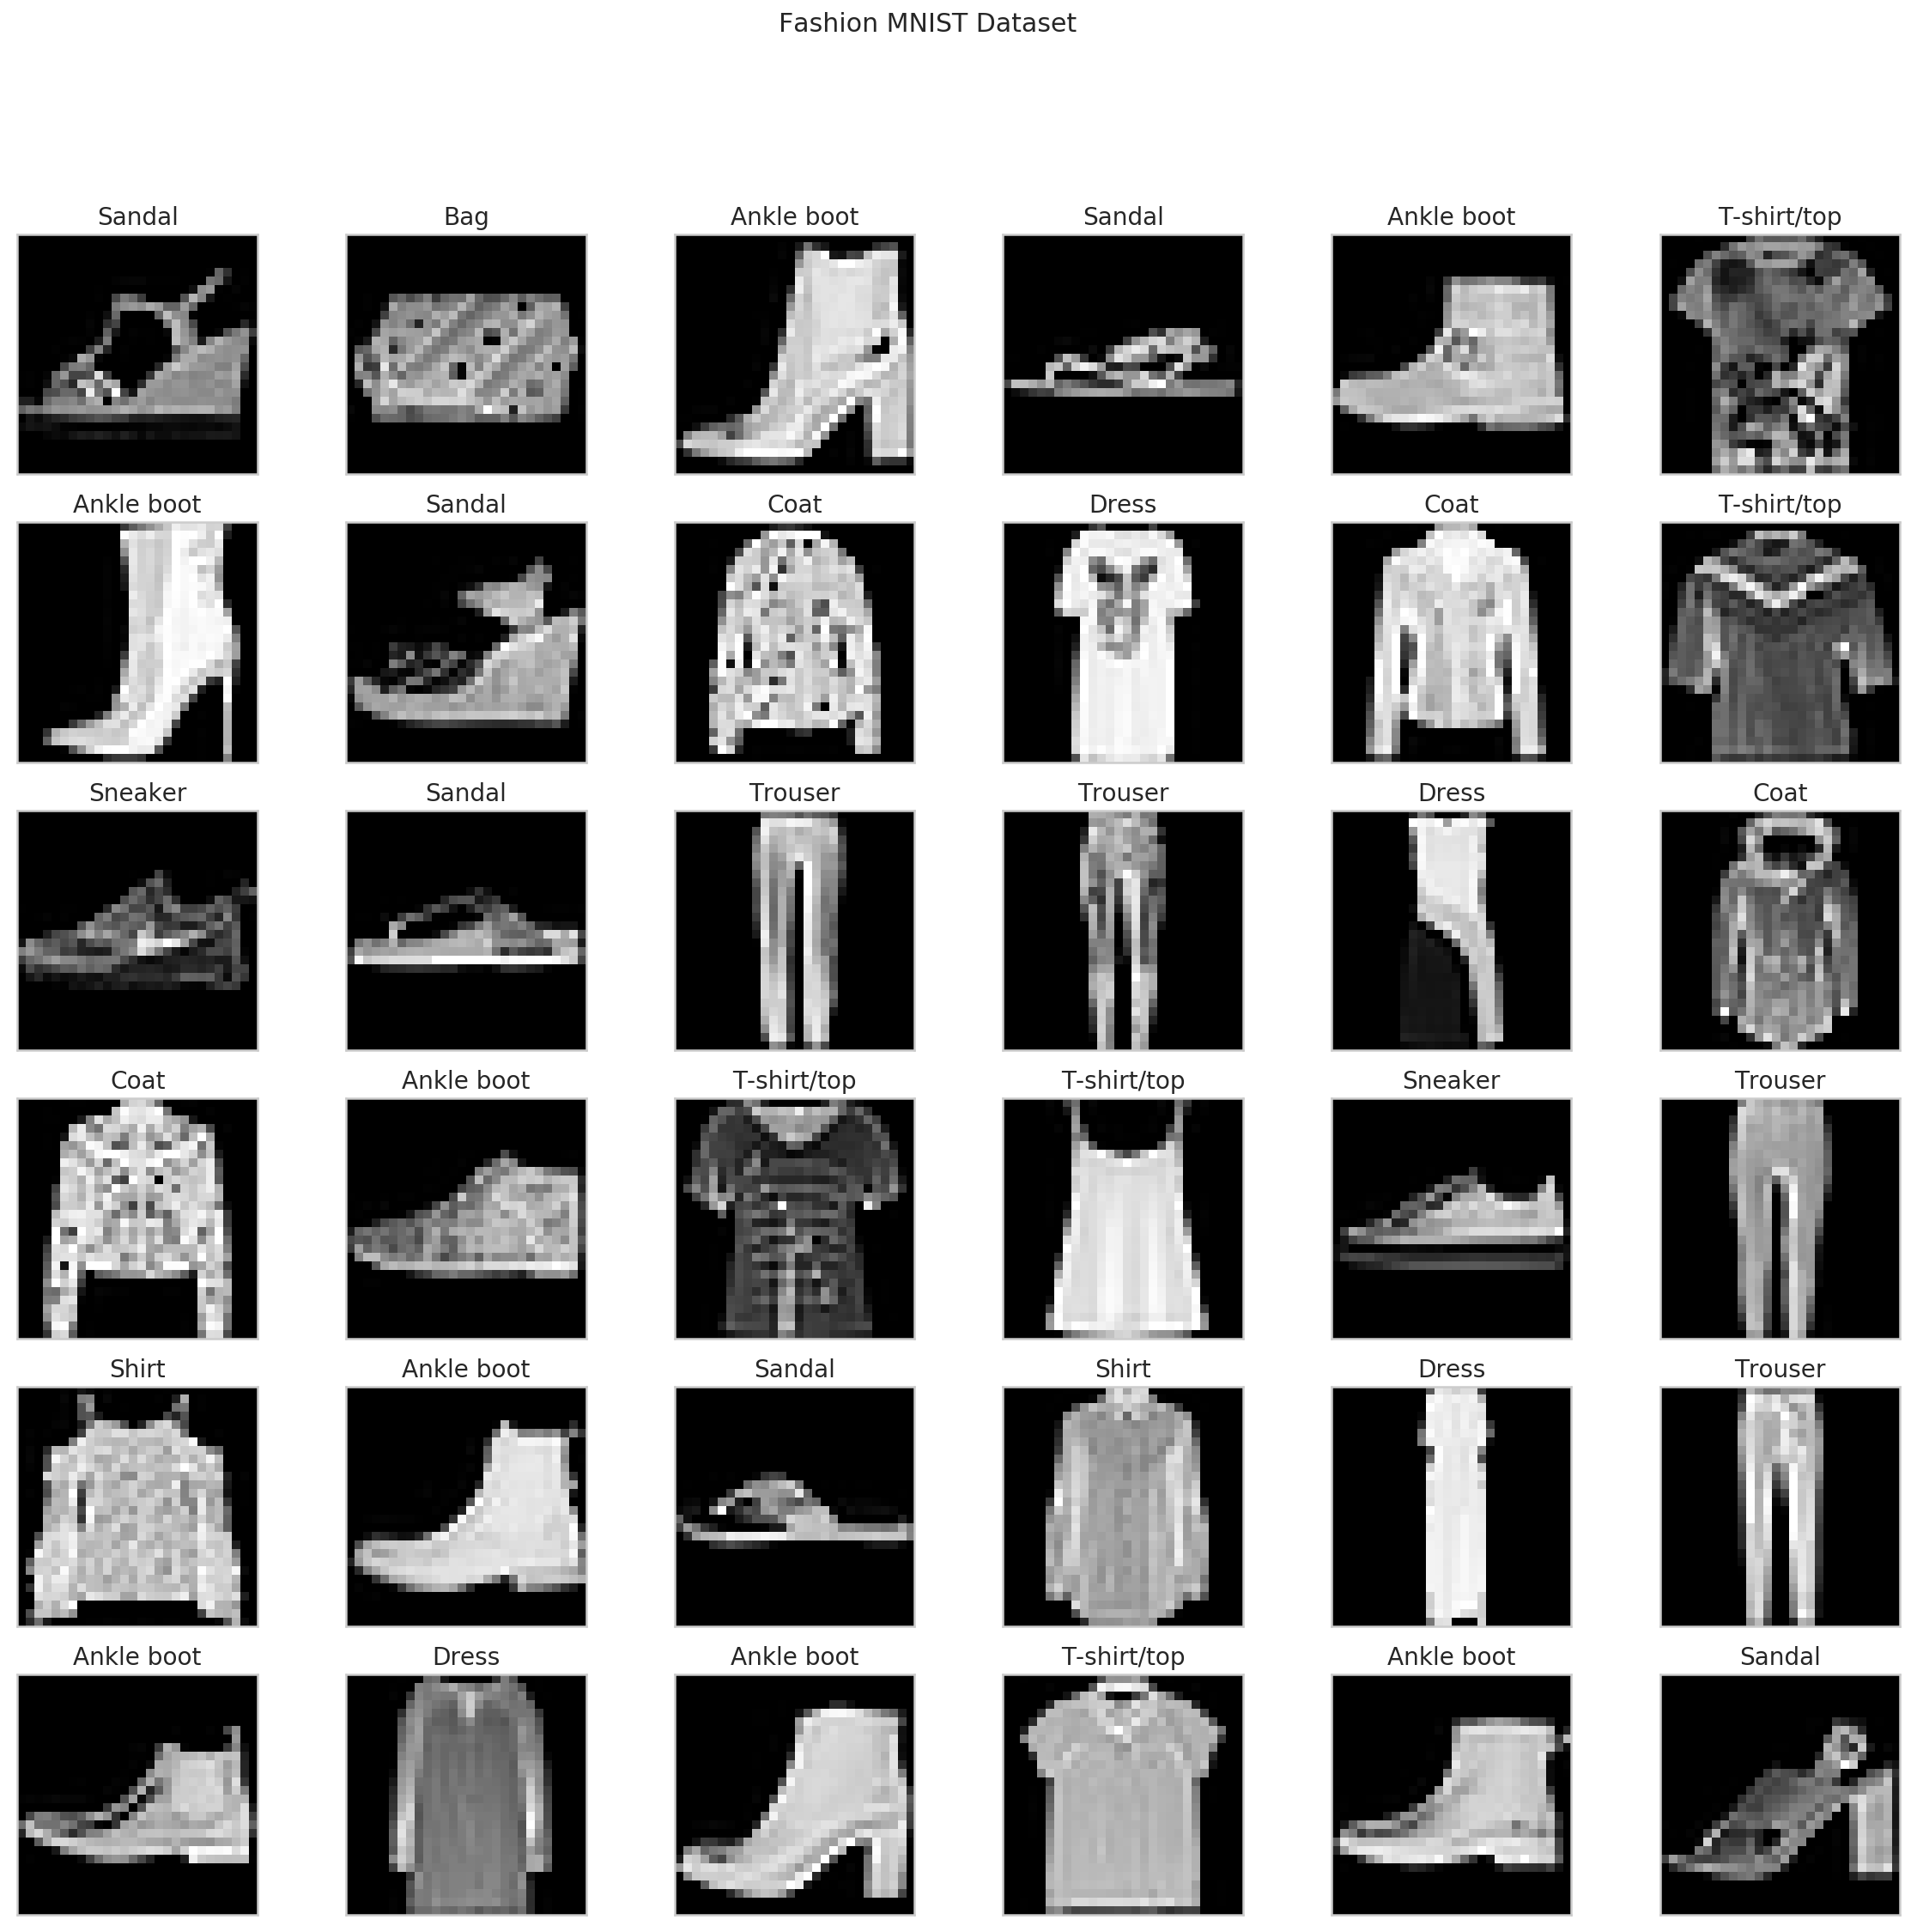

In [9]:
vizualize_fmnist(X_train, y_train)

In [10]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)

(48000, 784)
(48000,)
(10000, 784)
(10000,)
(12000, 784)


In [0]:
def vizualize_loss_accuracy(training_dict):
    training_keys = list(training_dict.keys())
    plt.figure(figsize=(18,16))
    for idx in range(len(training_keys)):
        plt.subplot(2,2,1)
        plt.plot(training_dict[training_keys[idx]][0], label = f"Hidden neurons {training_keys[idx]}")
        plt.legend()
        plt.xlabel("Epochs")
        plt.ylabel("Training Loss")

        plt.subplot(2,2,2)
        plt.plot(training_dict[training_keys[idx]][1], label = f"Hidden neurons {training_keys[idx]}")
        plt.legend()
        plt.xlabel("Epochs")
        plt.ylabel("Validation Loss")

        plt.subplot(2,2,3)
        plt.plot(training_dict[training_keys[idx]][2], label = f"Hidden neurons {training_keys[idx]}")
        plt.legend()
        plt.xlabel("Epochs")
        plt.ylabel("Training Accuracy")

        plt.subplot(2,2,4)
        plt.plot(training_dict[training_keys[idx]][3], label = f"Hidden neurons {training_keys[idx]}")
        plt.legend()
        plt.xlabel("Epochs")
        plt.ylabel("Validation Accuracy")

        plt.tight_layout()

In [0]:
def main(X_train, y_train, X_val, y_val):
    D = 784 
    size = [10, 20, 30, 40] 
    K = 10 

    #X = X_train[:20000, :]
    #Y = y_train[:20000]
    
    X = X_train
    Y = y_train
    
    N = len(Y)
    N_val = len(y_val)
    
    T = np.zeros((N, K))
    T_val = np.zeros((N_val, K))
    
    for i in range(N):
        T[i, Y[i]] = 1
    
    for i in range(N_val):
        T_val[i, y_val[i]] = 1

    learning_rate = 1e-4
    

    training_dict = {}
    parameters_dict = {}    

    for M in size:
        W1 = np.random.randn(D, M)
        b1 = np.random.randn(M)
        W2 = np.random.randn(M, K)
        b2 = np.random.randn(K)

        train_costs = []
        validation_costs = []
        train_accuracy = []
        validation_accuracy = []
        
        print(f"\nTraining with {M} number of hidden nodes.")
        
        for epoch in range(0,1000+1):
            output, hidden = forward(X, W1, b1, W2, b2)
            if epoch % 10 == 0:
                
                c = cost(T, output)
                P = np.argmax(output, axis=1)
                r = classification_rate(Y, P)
                
                train_accuracy.append(r)
                train_costs.append(c)
                
                output_val, hidden_val = forward(X_val, W1, b1, W2, b2)
                c_val = cost(T_val, output_val)
                validation_costs.append(c_val)
                predictions_val = np.argmax(output_val, axis=1)
                r_val = classification_rate(y_val, predictions_val)
                validation_accuracy.append(r_val)
                
                if epoch % 100 == 0:
                    print("Training Cost {:.3f} : Training Accuracy {:.2f}% : Validation Cost {:.3f} : Validation Accuracy {:.2f}%".format(c, r*100, c_val, r_val*100))
 
            W2 += learning_rate * derivative_w2(hidden, T, output)
            b2 += learning_rate * derivative_b2(T, output)
            W1 += learning_rate * derivative_w1(X, hidden, T, output, W2)
            b1 += learning_rate * derivative_b1(T, output, W2, hidden)

        parameters_dict[M] = {
            "W2":W2,
            "b2":b2,
            "W1":W1,
            "b1":b1
        }
        
        training_dict[M] = (train_costs, validation_costs, train_accuracy, validation_accuracy)

    return parameters_dict, training_dict

In [13]:
if __name__ == '__main__':
    parameters_dict, training_dict = main(X_train, y_train, X_val, y_val)


Training with 10 number of hidden nodes.
Training Cost 7.623 : Training Accuracy 3.30% : Validation Cost 7.621 : Validation Accuracy 3.60%
Training Cost 4.701 : Training Accuracy 33.70% : Validation Cost 4.651 : Validation Accuracy 34.00%
Training Cost 5.977 : Training Accuracy 44.23% : Validation Cost 5.912 : Validation Accuracy 44.40%
Training Cost 3.985 : Training Accuracy 45.07% : Validation Cost 3.973 : Validation Accuracy 44.94%
Training Cost 6.859 : Training Accuracy 45.24% : Validation Cost 6.736 : Validation Accuracy 45.08%
Training Cost 8.235 : Training Accuracy 45.91% : Validation Cost 8.323 : Validation Accuracy 45.46%
Training Cost 7.814 : Training Accuracy 45.93% : Validation Cost 7.714 : Validation Accuracy 46.27%
Training Cost 7.749 : Training Accuracy 46.13% : Validation Cost 7.645 : Validation Accuracy 45.86%
Training Cost 8.228 : Training Accuracy 46.58% : Validation Cost 8.320 : Validation Accuracy 46.09%
Training Cost 7.802 : Training Accuracy 46.54% : Validation 

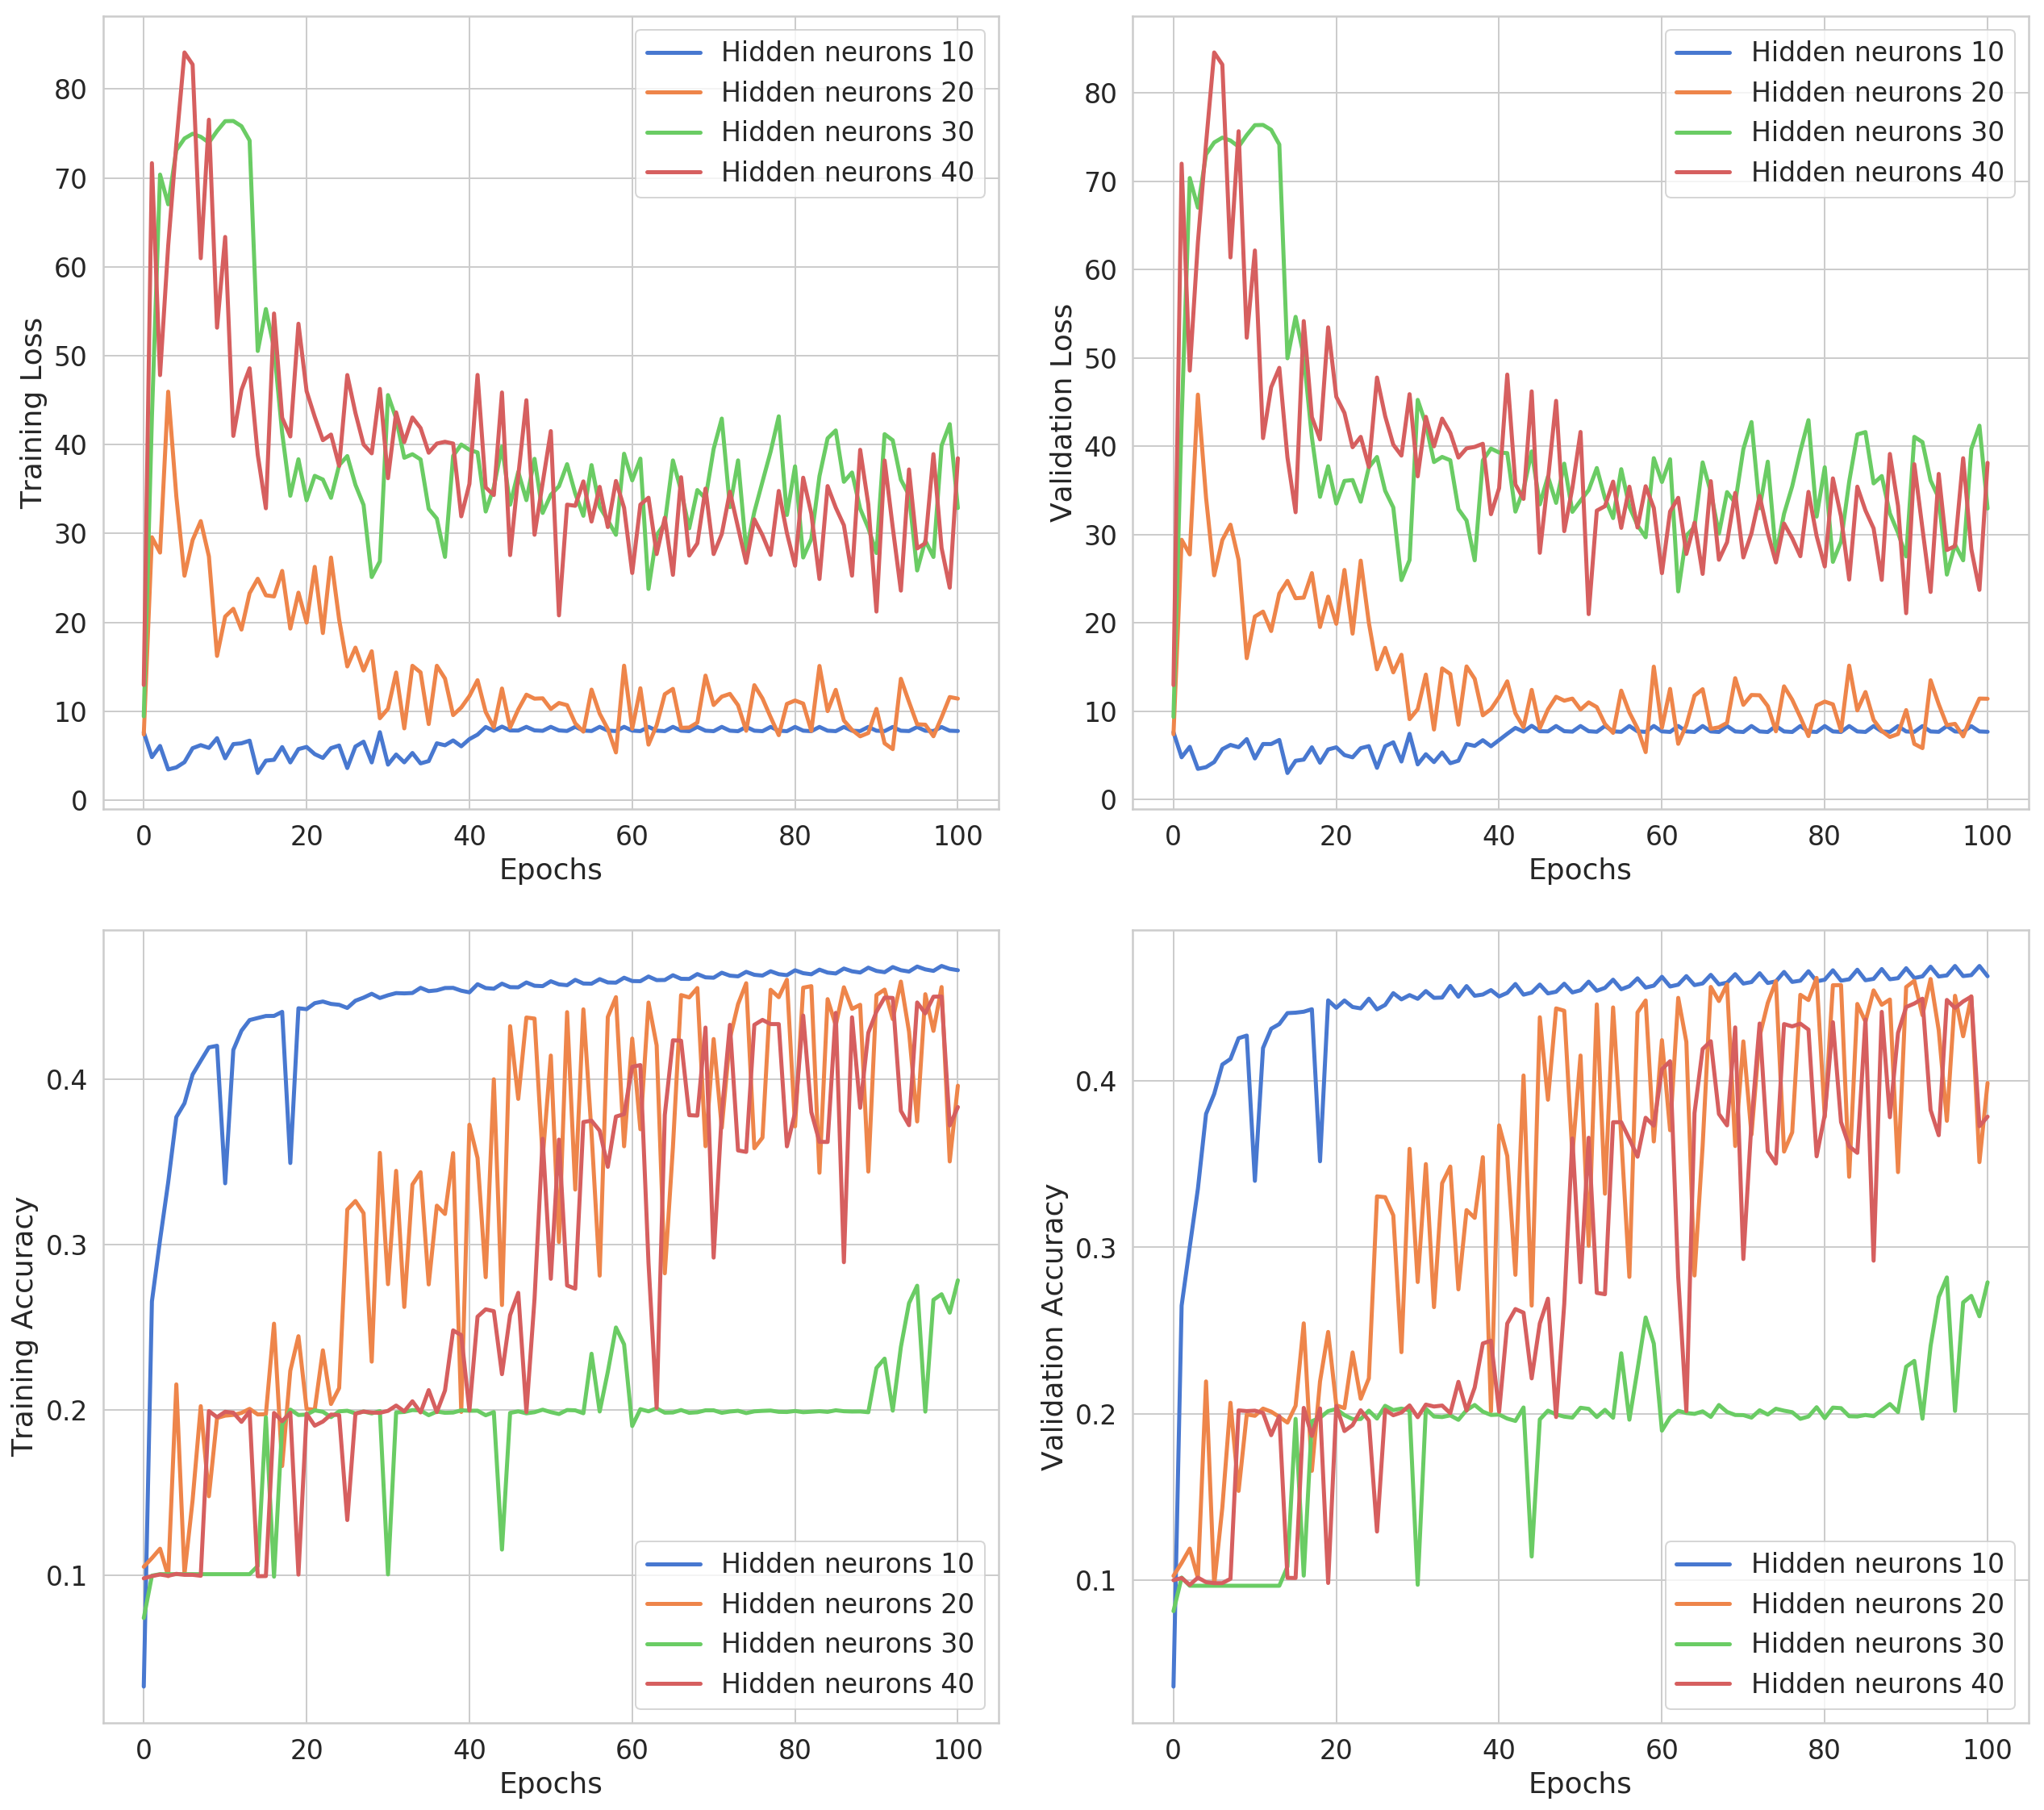

In [14]:
vizualize_loss_accuracy(training_dict)

In [15]:
print(X_test.shape)

(10000, 784)


In [0]:
W1 = parameters_dict[40]["W1"]
b1 = parameters_dict[40]["b1"]
W2 = parameters_dict[40]["W2"]
b2 = parameters_dict[40]["b2"]

In [0]:
output, hidden = forward(X_test, W1, b1, W2, b2)

In [0]:
predictions = np.argmax(output, axis=1)

In [0]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    plt.xlabel("{} {:2.0f}% ({})".format(labels[predicted_label],
                                100*np.max(predictions_array),
                                labels[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

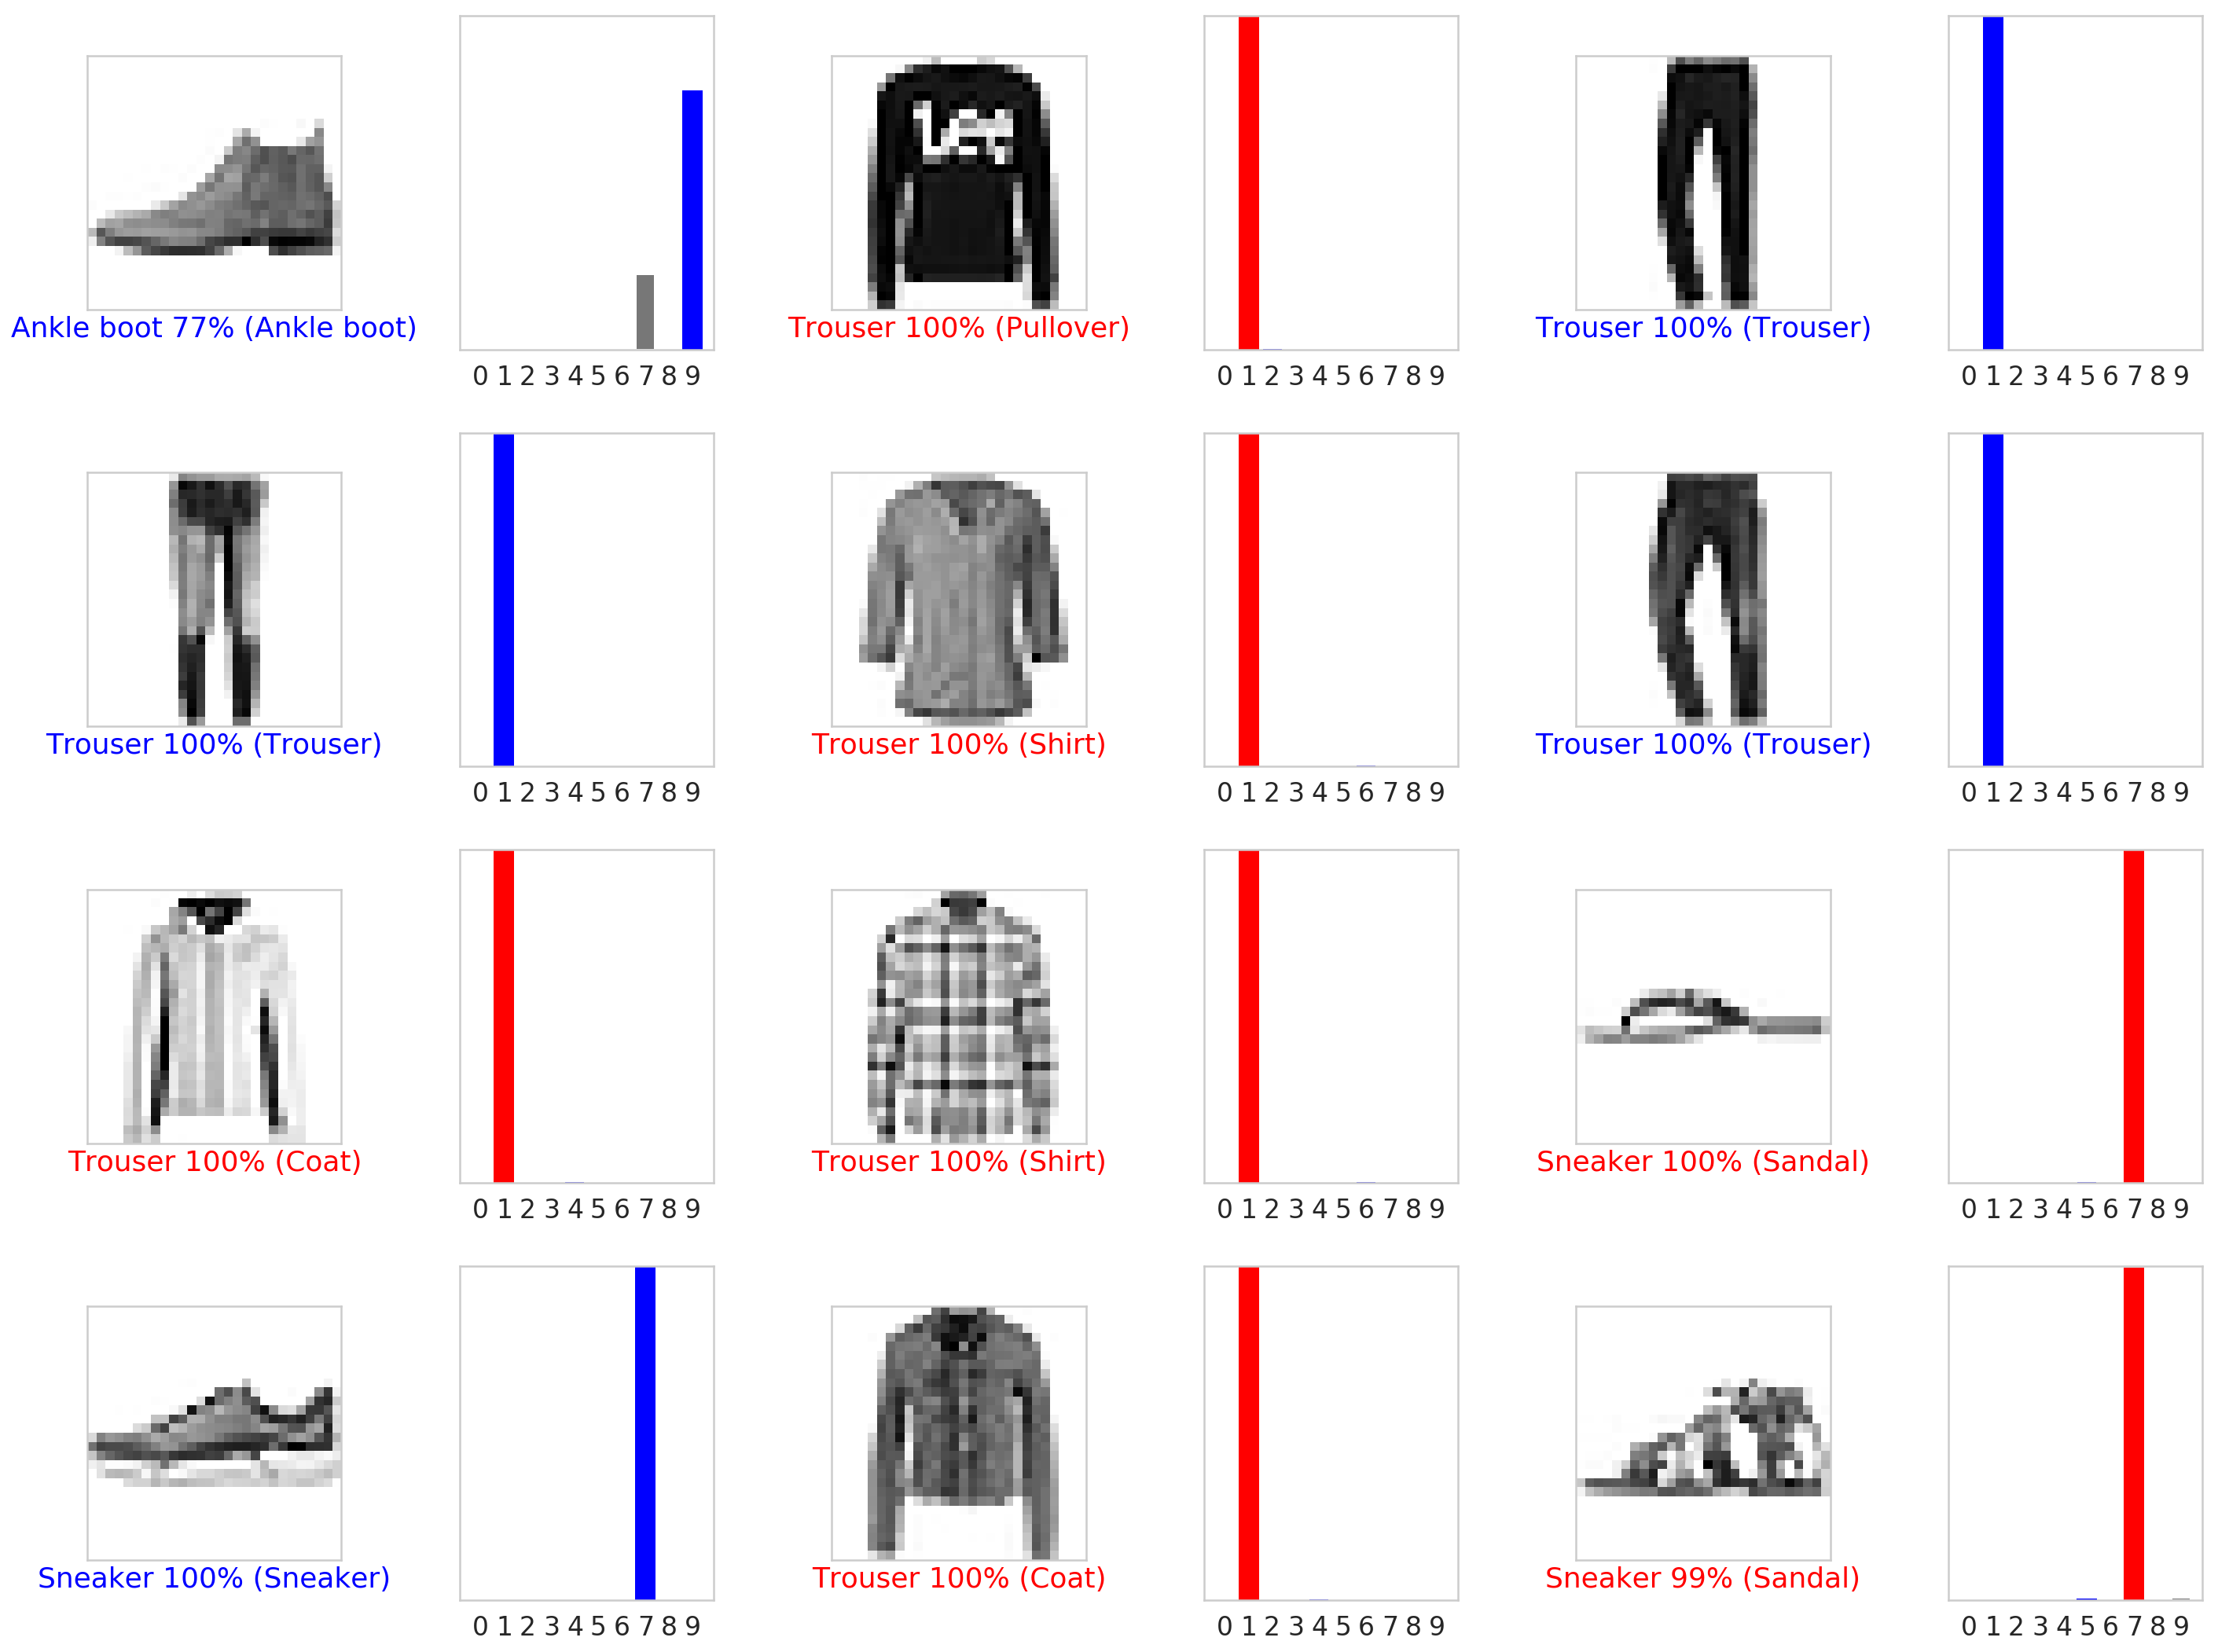

In [20]:
num_rows = 4
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(20, 15))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, output[i], y_test, X_test.reshape(-1, 28, 28))
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, output[i], y_test)
plt.tight_layout()
plt.show()

In [21]:
P = np.argmax(output, axis=1)
print(f"The accuracy of Shallow Neural Network with 40 hidden nodes is {np.round(classification_rate(y_test, P)*100)}%")

The accuracy of Shallow Neural Network with 40 hidden nodes is 38.0%


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 <a list of 10 Text yticklabel objects>)

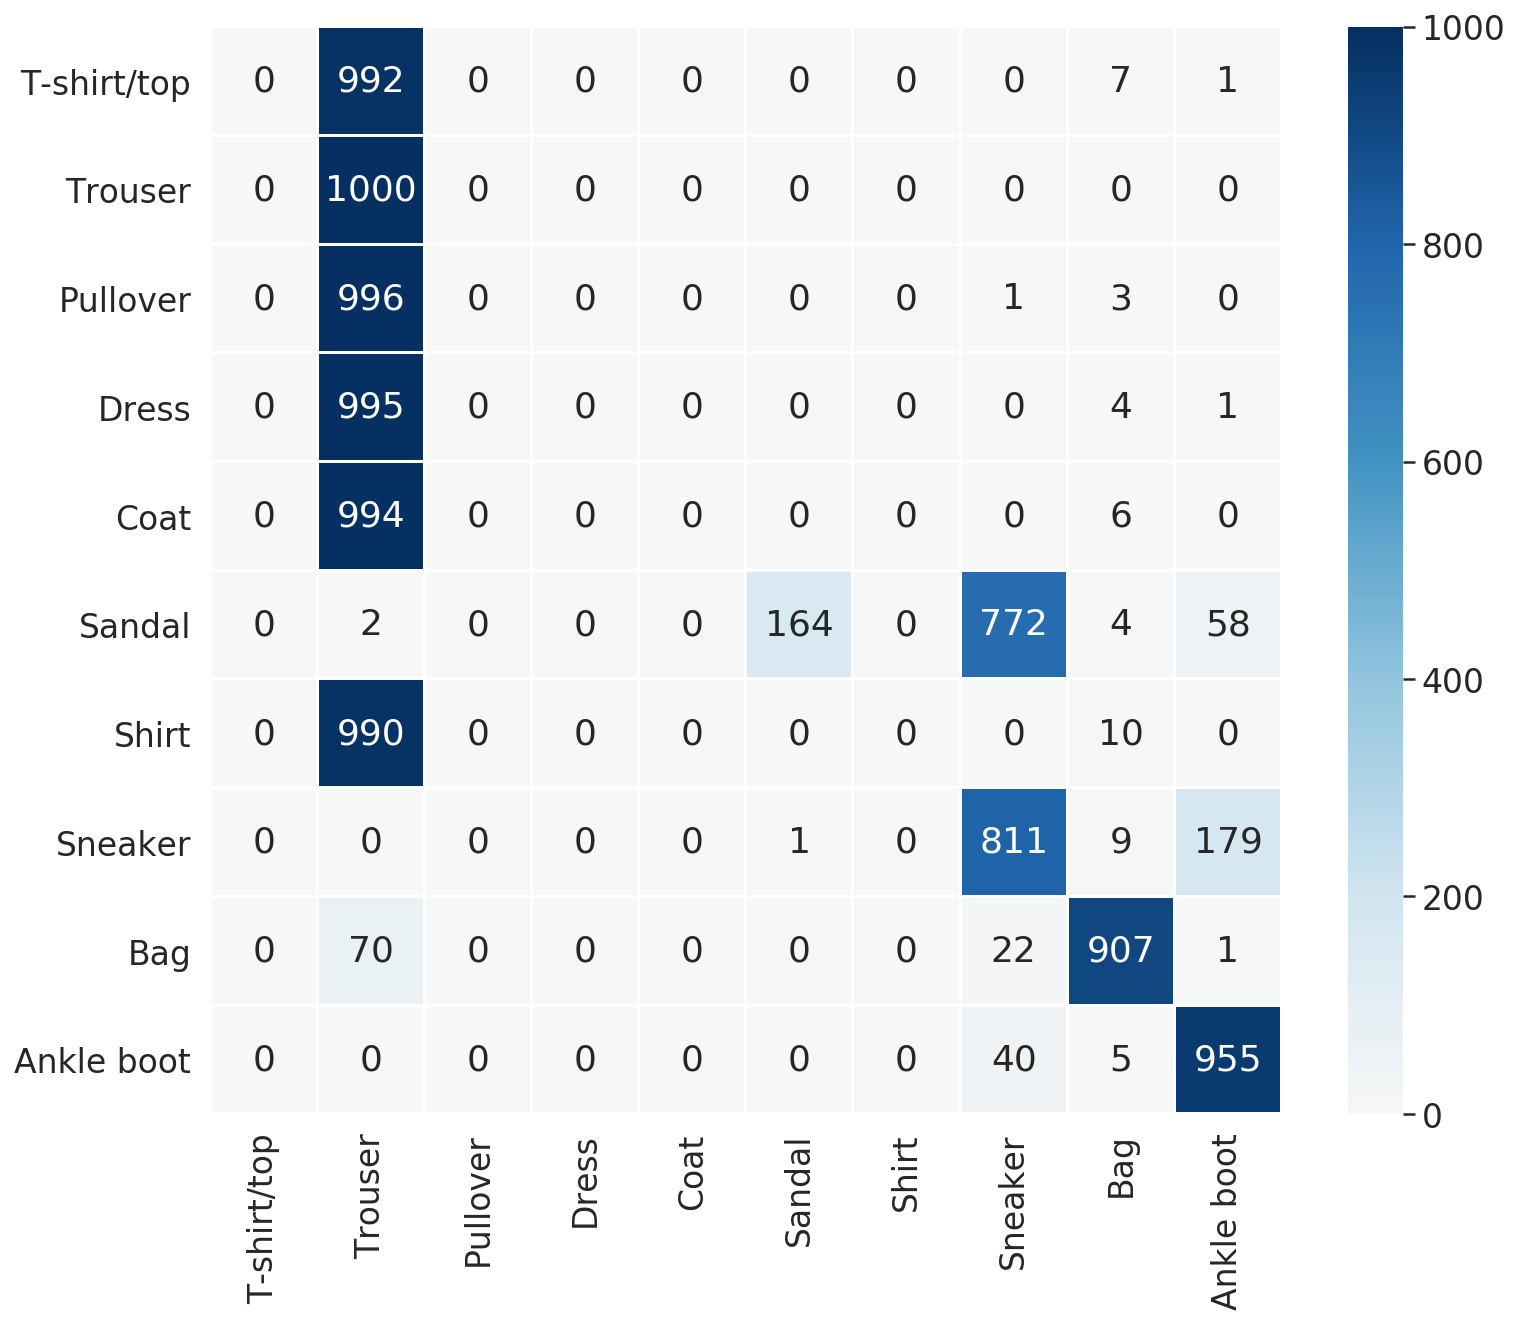

In [22]:
from sklearn.metrics import *
cm = confusion_matrix(y_test, P)
plt.figure(figsize=(12,10))
sns.heatmap(cm, center=0, annot=True, fmt=".0f",linewidths=1, cmap="RdBu",xticklabels=labels,yticklabels=labels)
plt.xticks(rotation=90)
plt.yticks(rotation=0)

In [23]:
print(classification_report(y_test, P, labels=np.unique(y_test).sort()))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.17      1.00      0.28      1000
           2       0.00      0.00      0.00      1000
           3       0.00      0.00      0.00      1000
           4       0.00      0.00      0.00      1000
           5       0.99      0.16      0.28      1000
           6       0.00      0.00      0.00      1000
           7       0.49      0.81      0.61      1000
           8       0.95      0.91      0.93      1000
           9       0.80      0.95      0.87      1000

    accuracy                           0.38     10000
   macro avg       0.34      0.38      0.30     10000
weighted avg       0.34      0.38      0.30     10000



### Deep Neural Network

In [24]:
X_train, X_test, X_val = X_train.reshape(-1, 28, 28), X_test.reshape(-1, 28, 28), X_val.reshape(-1, 28, 28)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(48000, 28, 28)
(10000, 28, 28)
(12000, 28, 28)


In [0]:
import time
dense_layers = [0,1]
layer_sizes = [32,64]

In [28]:
histories = {}
for dense_layer in dense_layers:
    for layer_size in layer_sizes:
            model_ckeckpoint = tf.keras.callbacks.ModelCheckpoint(filepath="{}-nodes-{}-dense.h5".format(layer_size, dense_layer), monitor="val_loss",verbose=1,save_best_only=True, save_weights_only=True)
            model = Sequential()
            model.add(Dense(layer_size, input_shape = X_train.shape[1:]))
            model.add(Activation("relu"))
            for l in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation("relu"))
            model.add(Flatten())
            model.add(Dense(10))
            model.add(Activation(activation="softmax"))
            model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics = ["accuracy"])
            history = model.fit(X_train,y_train,batch_size=2048,validation_data=(X_val, y_val),epochs=10, callbacks=[model_ckeckpoint])
            histories["{}-nodes-{}-dense".format(layer_size, dense_layer)] = history

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 48000 samples, validate on 12000 samples
Epoch 1/10
43008/48000 [=========================>....] - ETA: 0s - loss: 1.9171 - acc: 0.3740
Epoch 00001: val_loss improved from inf to 1.30556, saving model to 32-nodes-0-dense.h5
48000/48000 [==============================] - 1s 22us/sample - loss: 1.8613 - acc: 0.4002 - val_loss: 1.3056 - val_acc: 0.6308
Epoch 2/10
40960/48000 [========================>.....] - ETA: 0s - loss: 1.0533 - acc: 0.6902
Epoch 00002: val_loss improved from 1.30556 to 0.82075, saving model to 32-nodes-0-dense.h5
48000/48000 [==============================] - 0s 7us/sample - loss: 1.0235 - acc: 0.6964 - val_loss: 0.8207 - val_acc: 0.7482
Epoch 3/10
43008/48000 [=========================>....] - ETA: 0s - loss: 0.7377 - acc: 0.7631
Epoch 00003: val_loss improved from 0.82075 to 0.66490, saving model to 32-nodes-0-dense.h5
48000/48000 [==============================] - 0s 7us/sam

In [0]:
def plot_histories(history, key):    
    plt.subplot(121)
    g = plt.plot(history.epoch, history.history["loss"], label=key, marker='o')
    plt.plot(history.epoch, history.history["val_loss"], "--", marker='o', c= g[0].get_color())
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.suptitle("Training and Validation Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(122)
    g = plt.plot(history.epoch, history.history["acc"], label=key, marker='o')
    plt.plot(history.epoch, history.history["val_acc"], "--", marker='o', c= g[0].get_color())
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.suptitle("Training and Validation Accuracy")
    plt.grid(True)
    plt.legend()

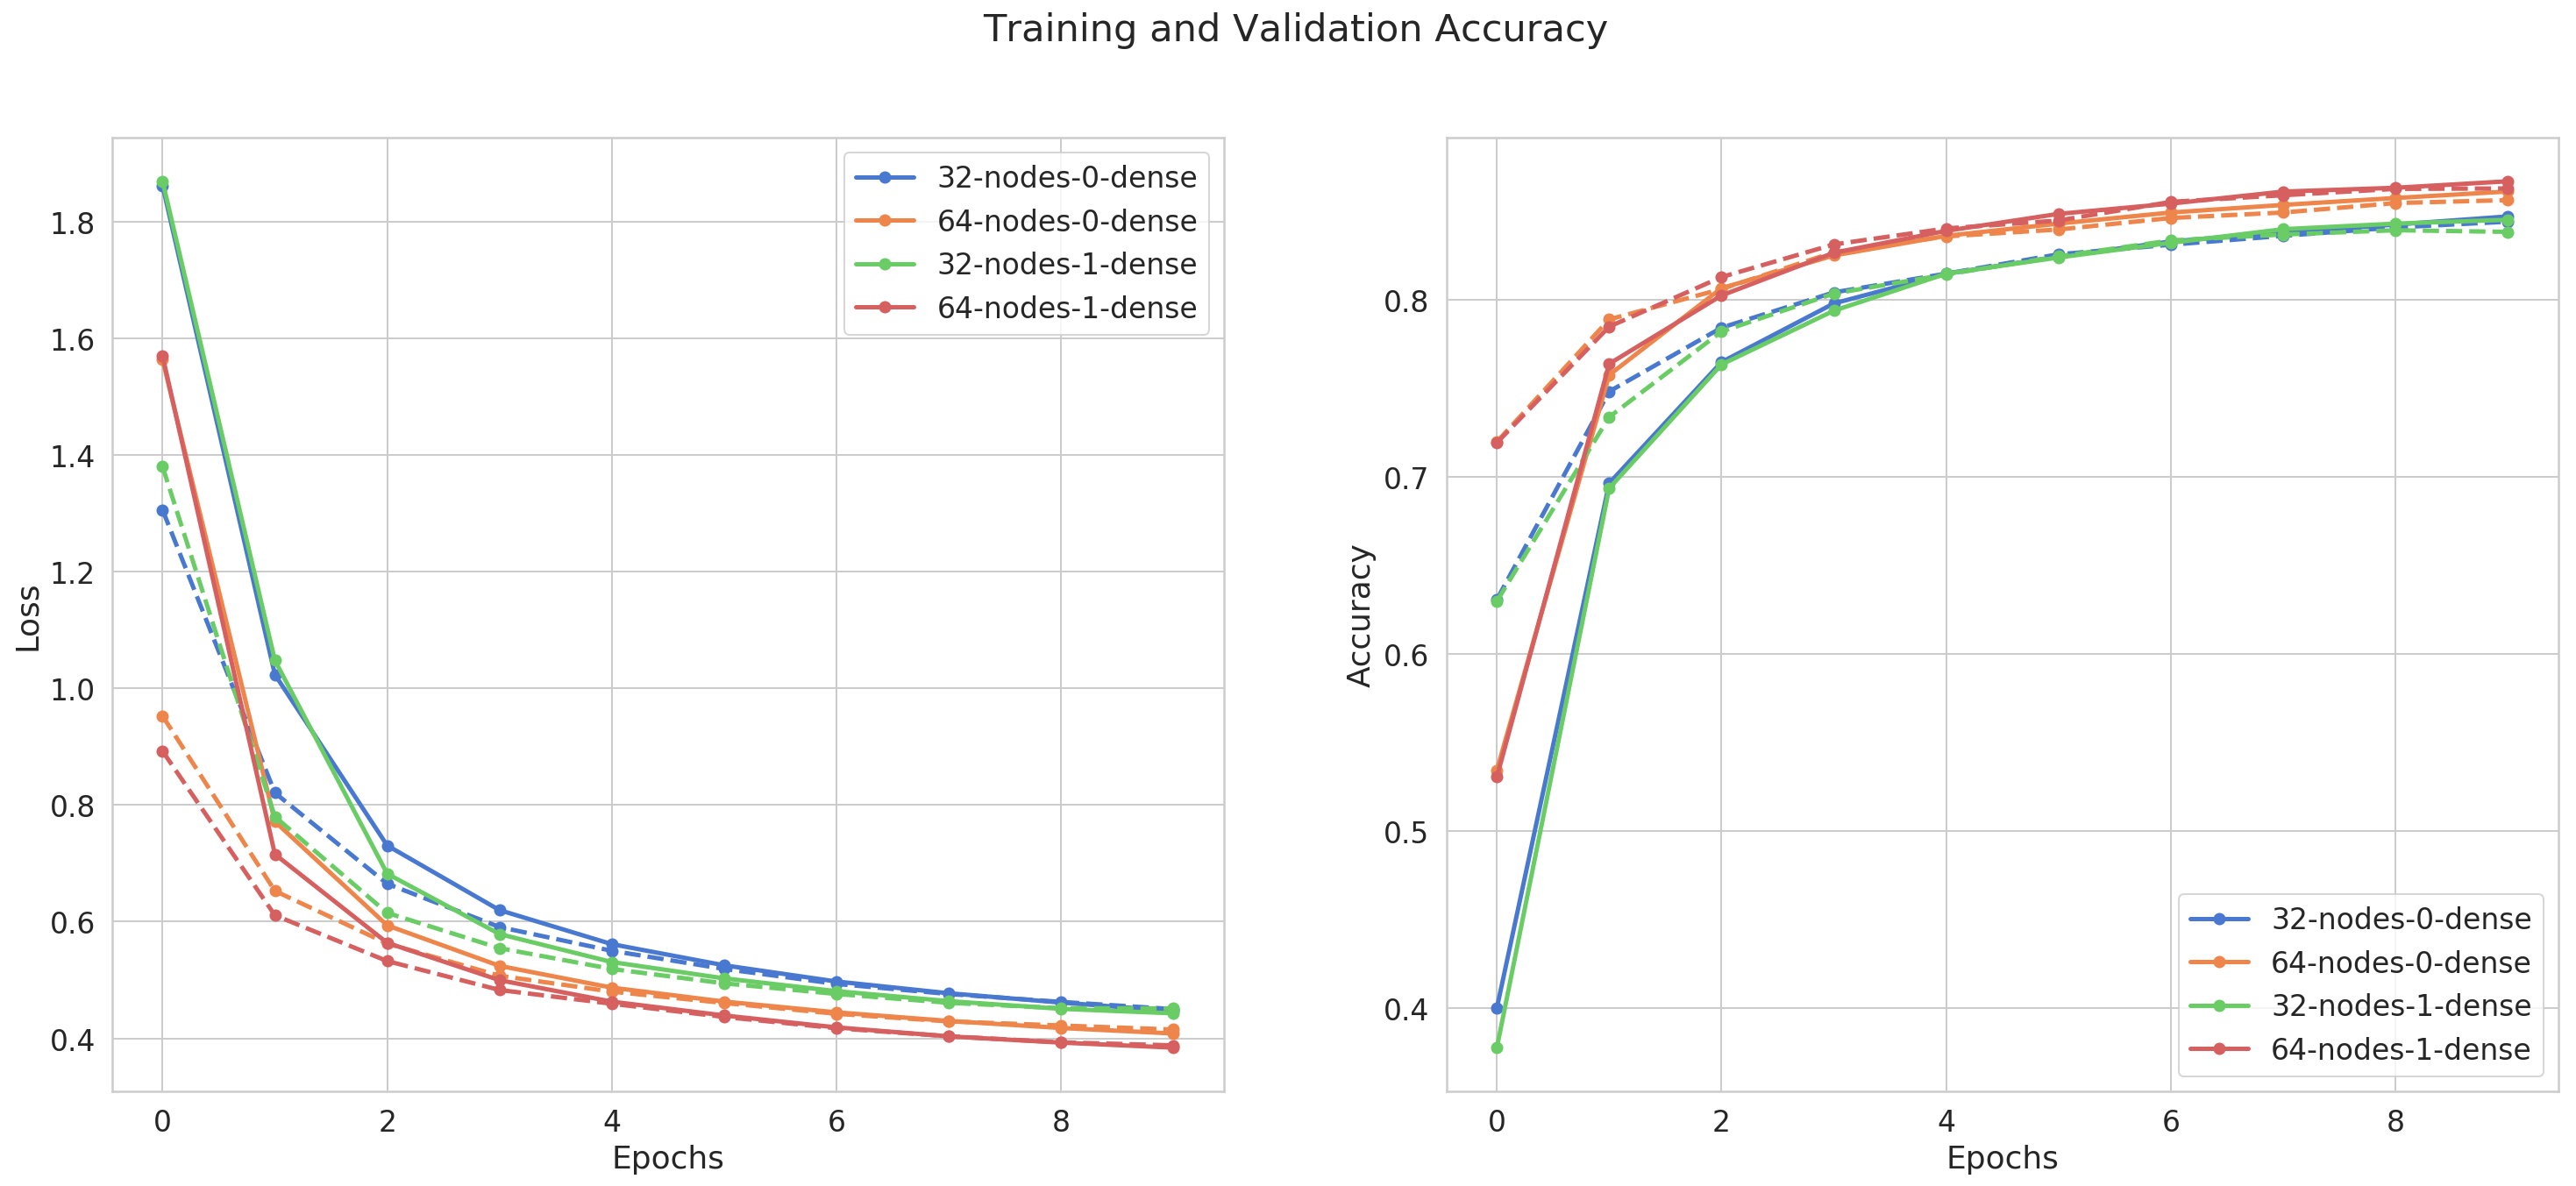

In [30]:
key = list(histories.keys())
plt.figure(figsize=(25,10))
for i in key:
    plot_histories(histories[i],i)

In [0]:
max_val_accuracy = 0
model_name = None
for i in key:
    if histories[i].history["val_acc"][-1] > max_val_accuracy:
        max_val_acc = histories[i].history["val_acc"][-1]
        model_name = i

In [32]:
print(f"The best hyperparameters are: {model_name}")

The best hyperparameters are: 64-nodes-1-dense


In [0]:
model.load_weights(f"{model_name}.h5")

In [0]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0, batch_size=1024)

In [36]:
for name, value in zip(model.metrics_names, (loss, accuracy)):
    print(name, ":", value)

loss : 0.4163197916507721
acc : 0.8526


In [0]:
pred = model.predict(X_test)

In [0]:
predictions = np.argmax(pred, axis=1)

In [40]:
print(f"The accuracy of the model is: {accuracy_score(predictions, y_test)*100}%")

The accuracy of the model is: 85.26%


In [41]:
print(classification_report(y_test, predictions, labels=np.arange(0,10)))

              precision    recall  f1-score   support

           0       0.82      0.79      0.80      1000
           1       0.97      0.96      0.97      1000
           2       0.79      0.72      0.75      1000
           3       0.84      0.87      0.85      1000
           4       0.73      0.81      0.77      1000
           5       0.94      0.94      0.94      1000
           6       0.65      0.61      0.63      1000
           7       0.92      0.92      0.92      1000
           8       0.93      0.96      0.94      1000
           9       0.94      0.94      0.94      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



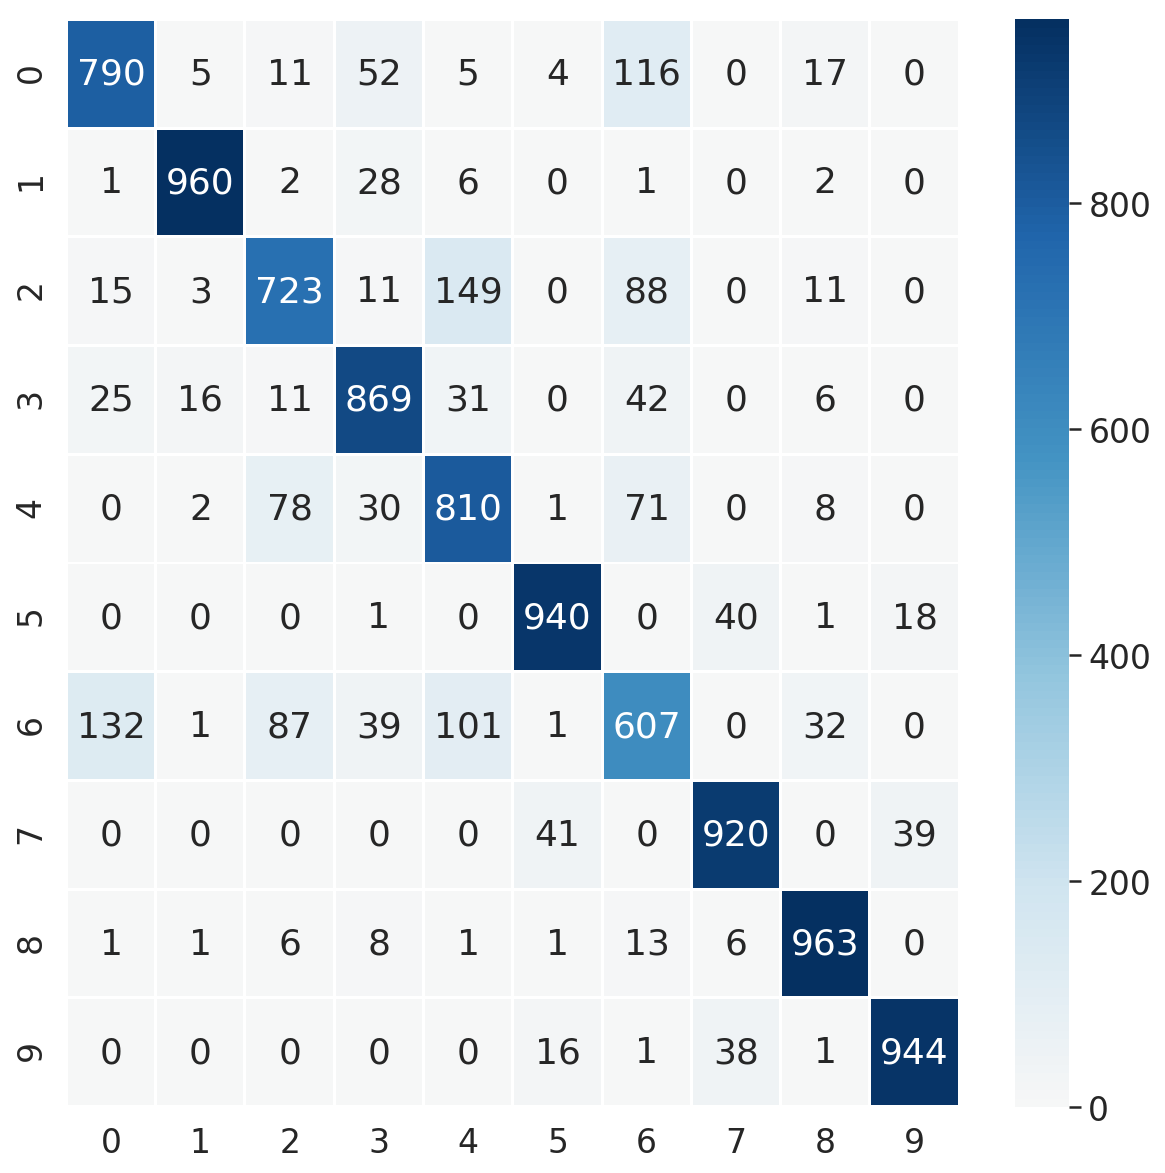

In [43]:
plt.figure(figsize=(10,10))
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, center=0, linewidth=1, fmt="d", annot=True,cmap="RdBu")

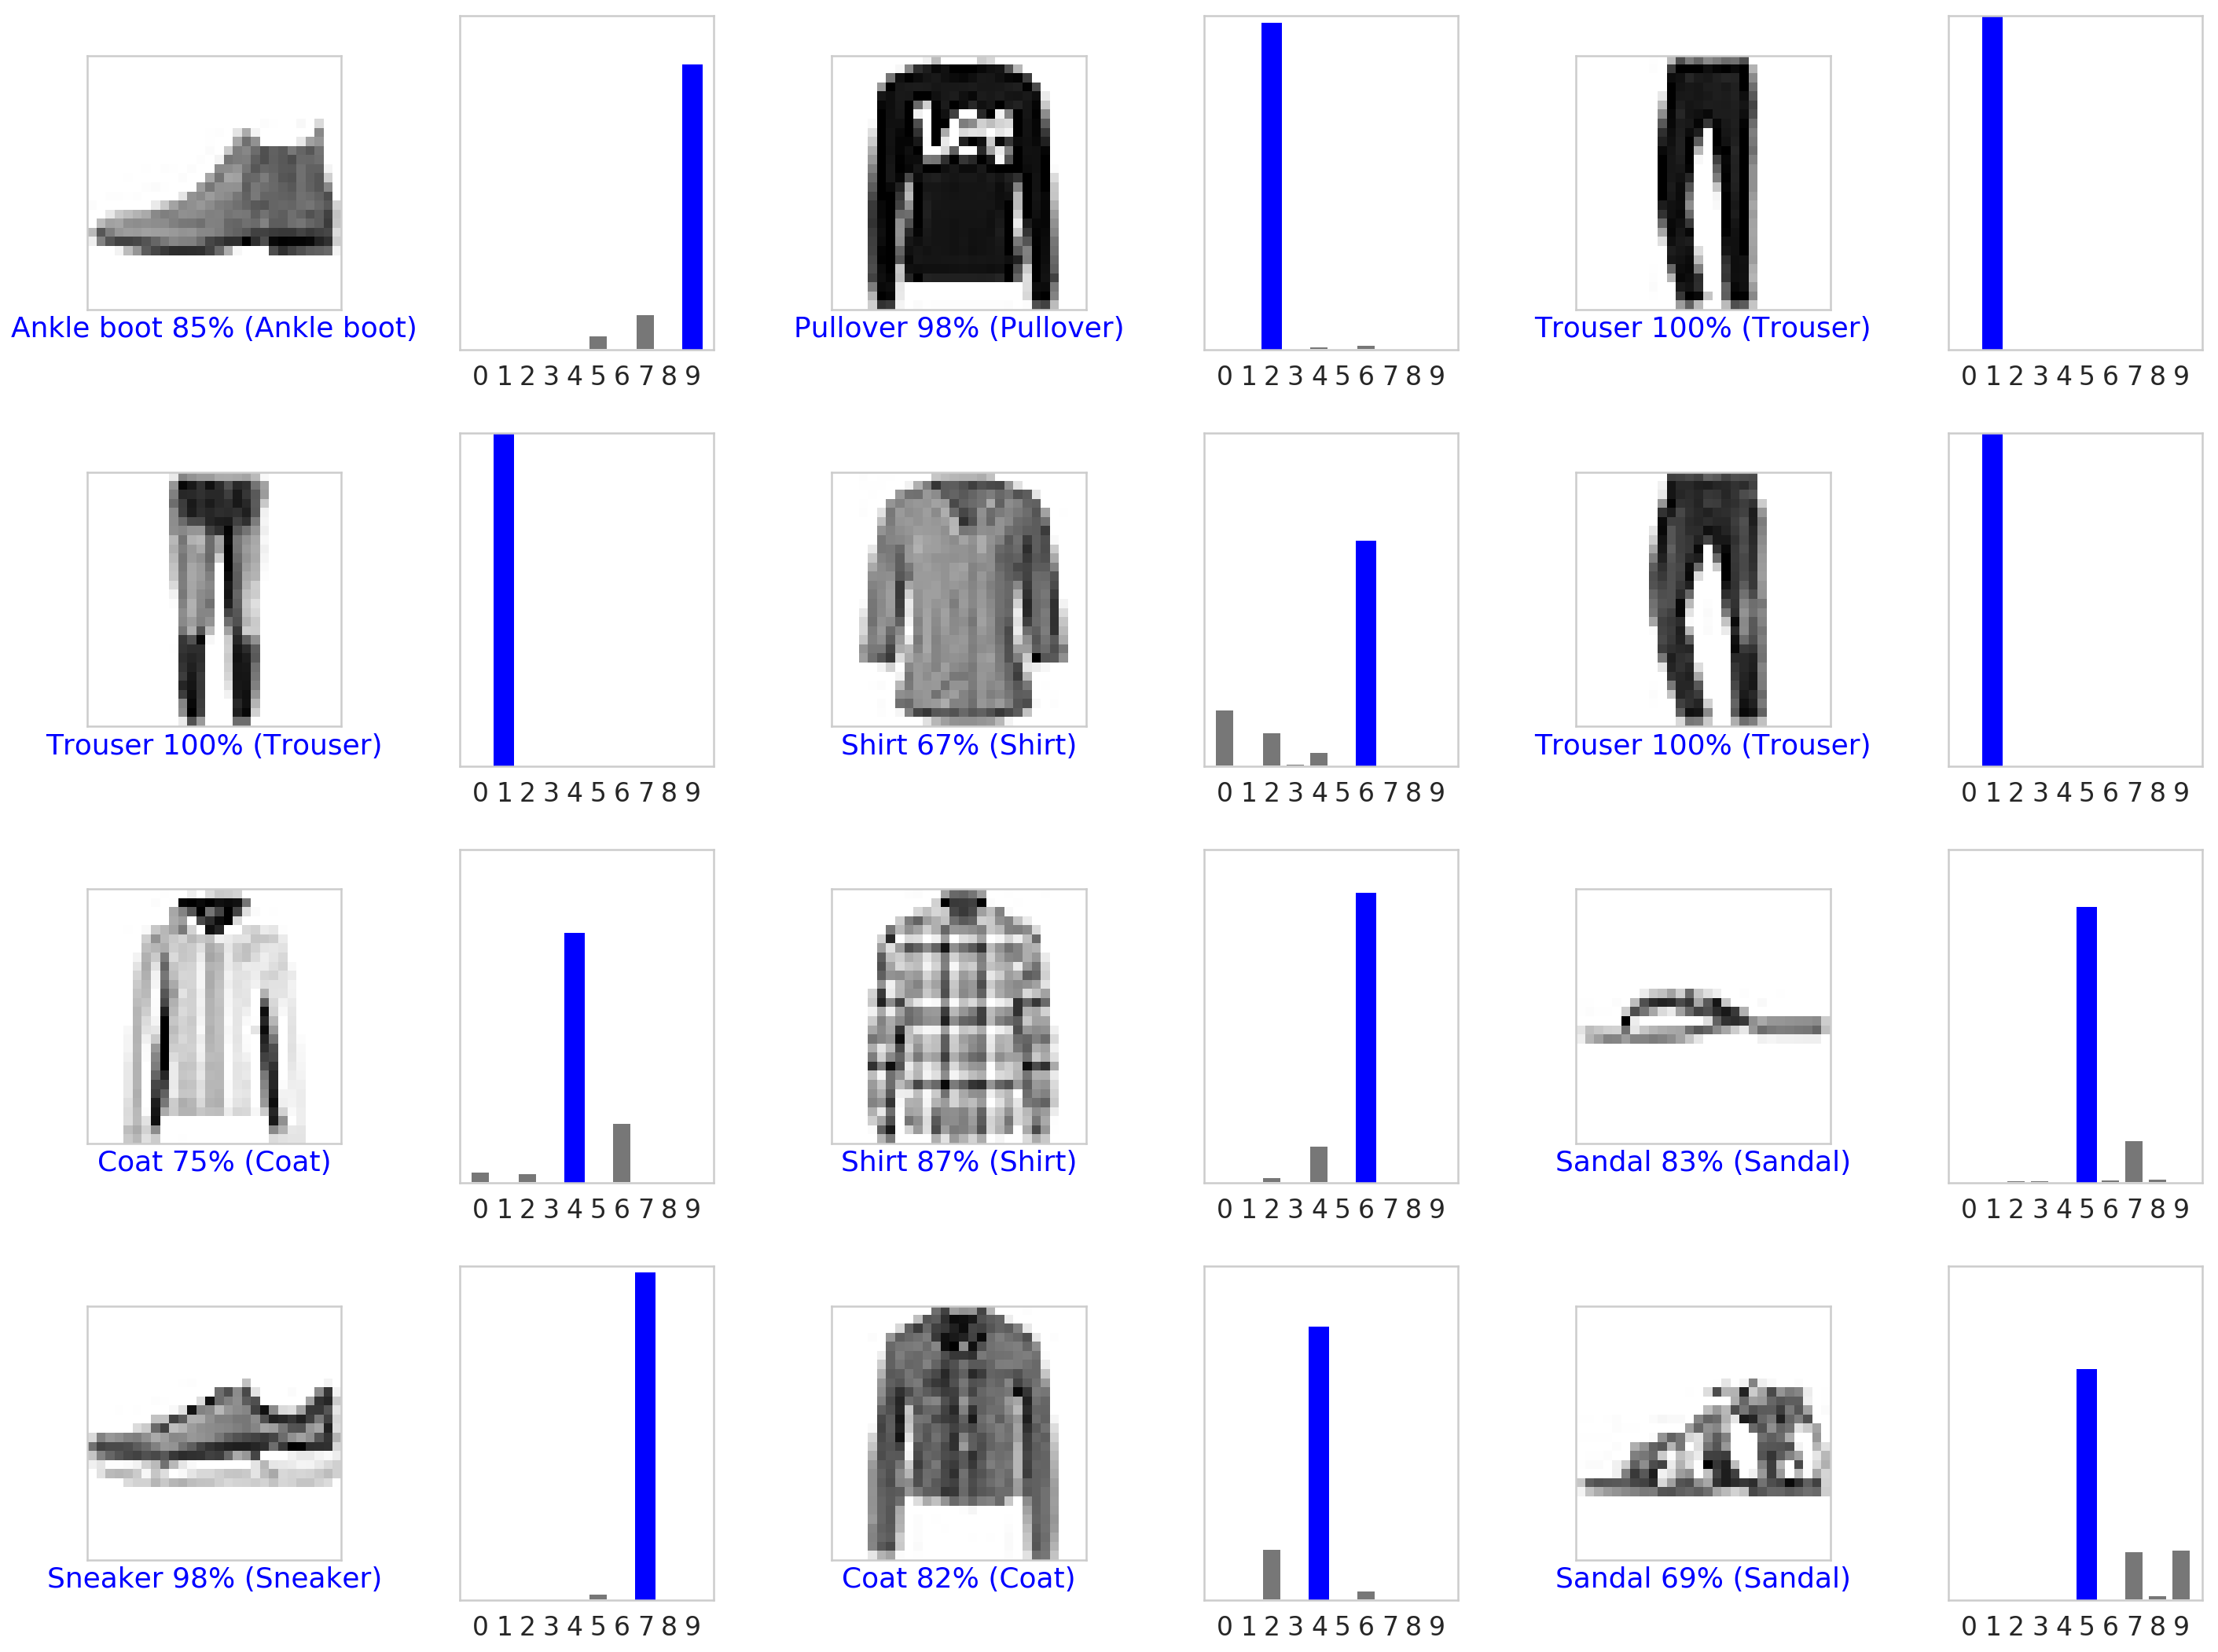

In [45]:
num_rows = 4
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(20, 15))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, pred[i], y_test, X_test.reshape(-1, 28, 28))
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, pred[i], y_test)
plt.tight_layout()
plt.show()

### Convolutional Neural Network

In [46]:
X_train, X_test, X_val = X_train.reshape(X_train.shape + (1,)), X_test.reshape(X_test.shape + (1,)), X_val.reshape(X_val.shape + (1,))

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(48000, 28, 28, 1)
(10000, 28, 28, 1)
(12000, 28, 28, 1)


In [0]:
import time
dense_layers = [0,1]
layer_sizes = [32,64]
conv_layers = [1,2]

In [58]:
histories = {}
for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            model_ckeckpoint = tf.keras.callbacks.ModelCheckpoint(filepath="{}-nodes-{}-dense-{}-conv.h5".format(layer_size, dense_layer, conv_layer), monitor="val_loss",verbose=1,save_best_only=True, save_weights_only=True)
            model = Sequential()
            model.add(Conv2D(layer_size, (3,3), input_shape = X_train.shape[1:]))
            model.add(Activation("relu"))
            model.add(MaxPool2D(pool_size=(2,2)))
            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3,3), input_shape = X_train.shape[1:]))
                model.add(Activation("relu"))
                model.add(MaxPool2D(pool_size=(2,2)))
            for l in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation("relu"))
            model.add(Flatten())
            model.add(Dense(10))
            model.add(Activation(activation="softmax"))
            model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics = ["accuracy"])
            history = model.fit(X_train, y_train, batch_size=2048, validation_data=(X_val, y_val), callbacks=[model_ckeckpoint], epochs=10)
            histories["{}-nodes-{}-dense-{}-conv".format(layer_size, dense_layer,conv_layer)] = history

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
45056/48000 [===========================>..] - ETA: 0s - loss: 1.4205 - acc: 0.6091
Epoch 00001: val_loss improved from inf to 0.78379, saving model to 32-nodes-0-dense-1-conv.h5
48000/48000 [==============================] - 2s 33us/sample - loss: 1.3834 - acc: 0.6174 - val_loss: 0.7838 - val_acc: 0.7467
Epoch 2/10
47104/48000 [============================>.] - ETA: 0s - loss: 0.6685 - acc: 0.7748
Epoch 00002: val_loss improved from 0.78379 to 0.59764, saving model to 32-nodes-0-dense-1-conv.h5
48000/48000 [==============================] - 1s 21us/sample - loss: 0.6677 - acc: 0.7748 - val_loss: 0.5976 - val_acc: 0.7886
Epoch 3/10
47104/48000 [============================>.] - ETA: 0s - loss: 0.5514 - acc: 0.8115
Epoch 00003: val_loss improved from 0.59764 to 0.52310, saving model to 32-nodes-0-dense-1-conv.h5
48000/48000 [==============================] - 1s 21us/sample - loss: 0.5520 - acc: 0.8112 - val_loss: 0.5231 - val_

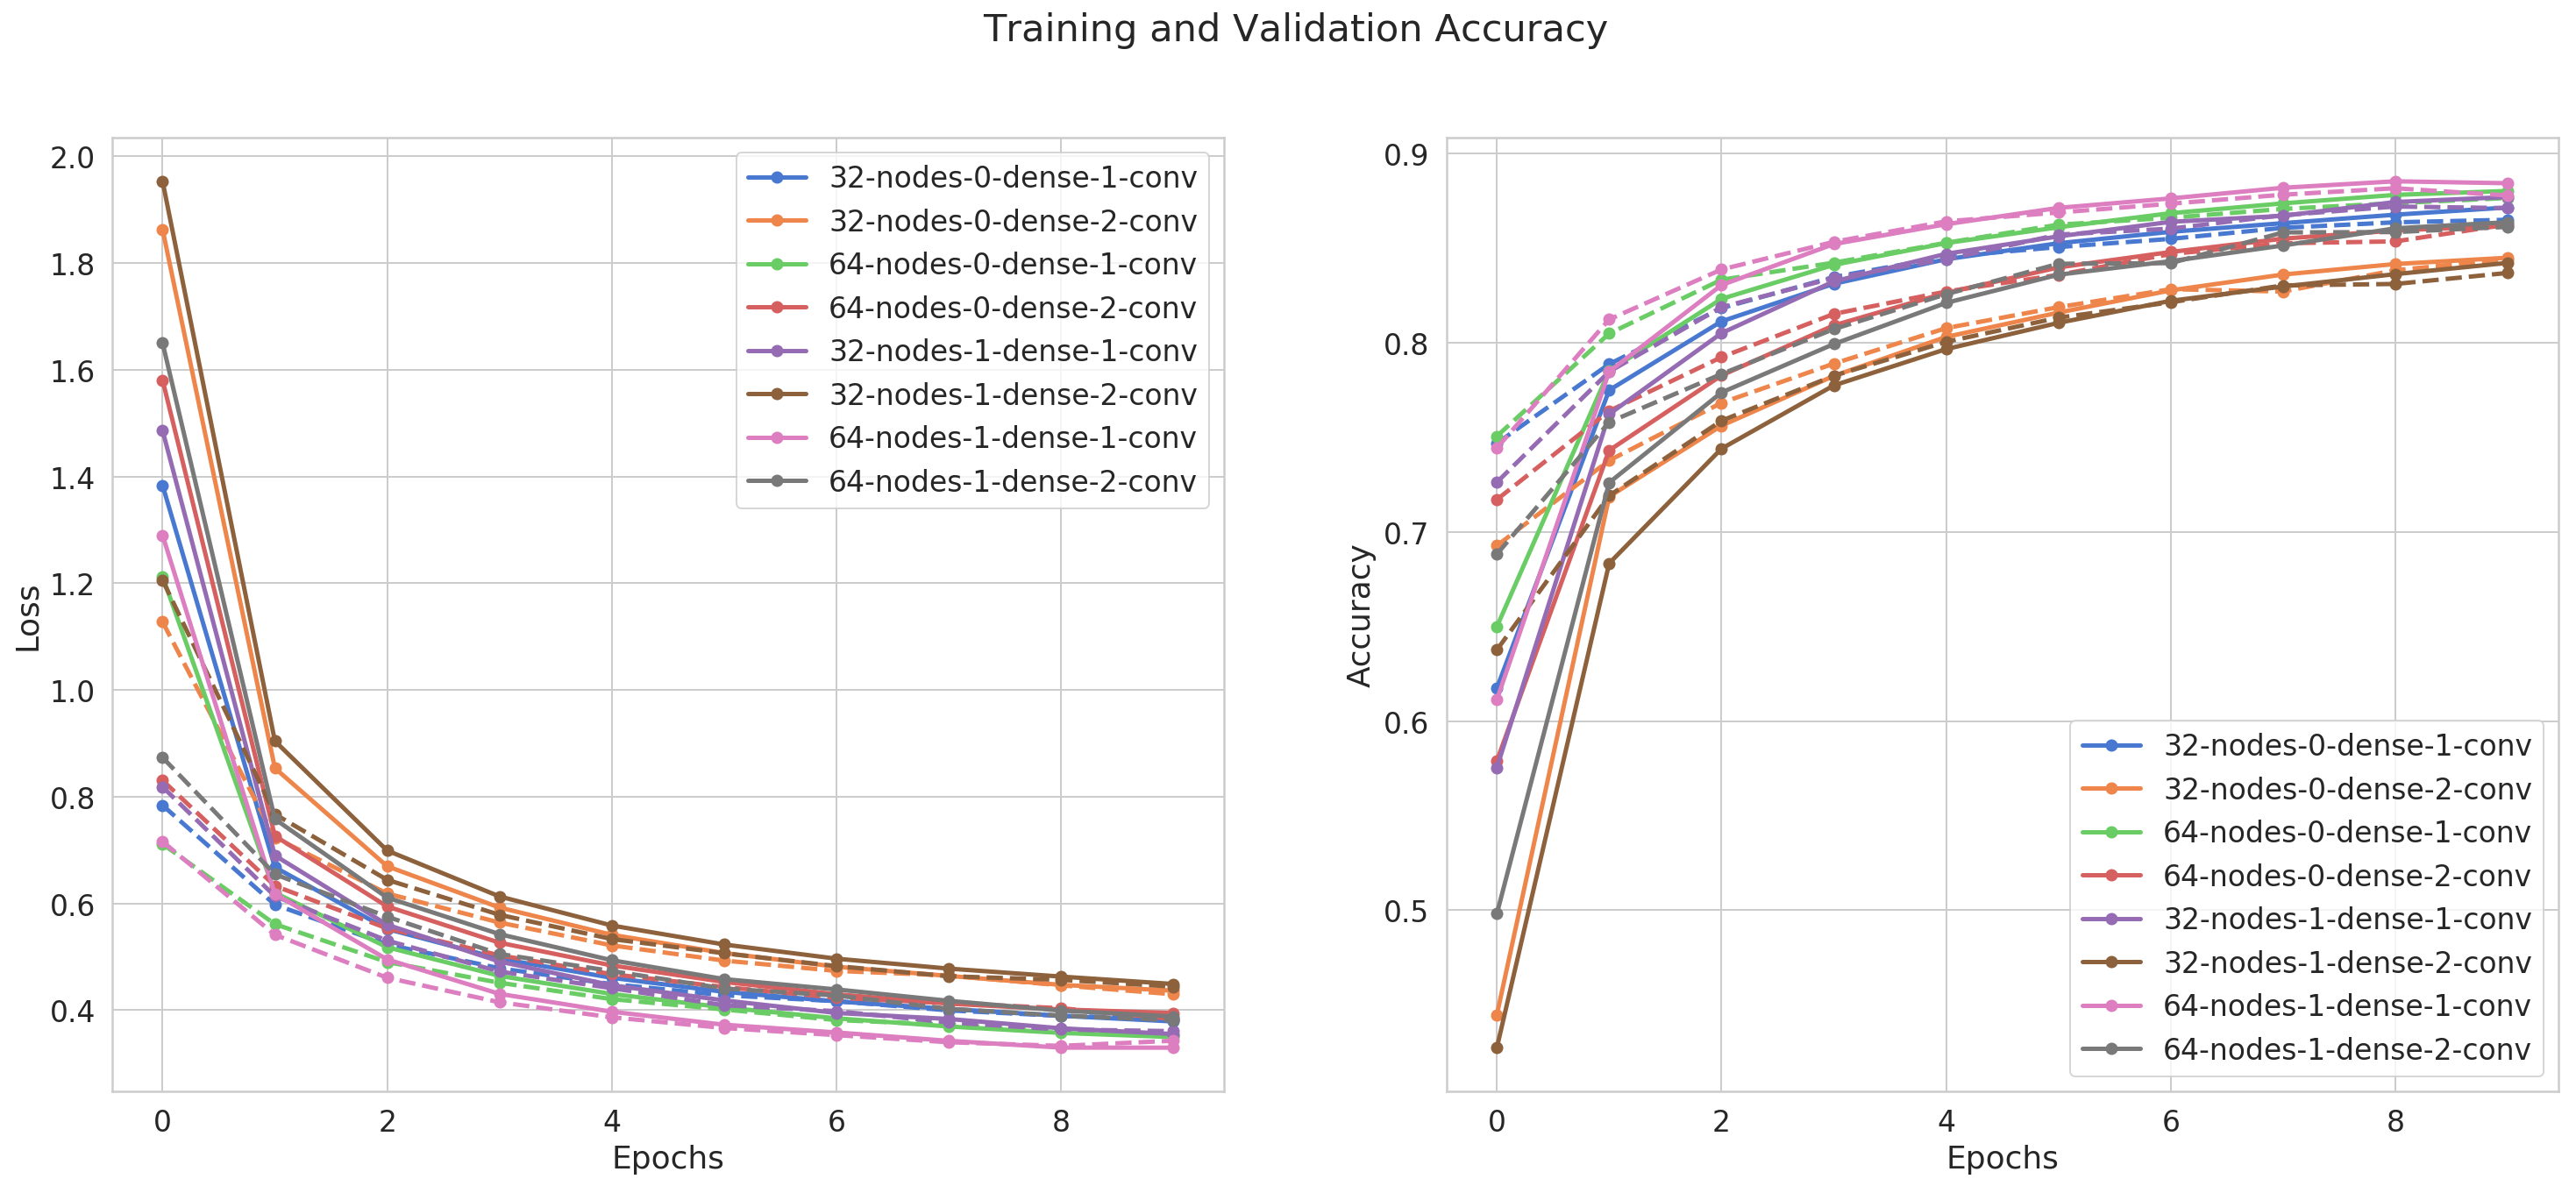

In [59]:
key = list(histories.keys())
plt.figure(figsize=(25,10))
for i in key:
    plot_histories(histories[i],i)

In [0]:
max_val_accuracy = 0
model_name = None
for i in key:
    if histories[i].history["val_acc"][-1] > max_val_accuracy:
        max_val_acc = histories[i].history["val_acc"][-1]
        model_name = i

In [61]:
print(f"The best model hyperparameters is {model_name}") 

The best model hyperparameters is 64-nodes-1-dense-2-conv


In [0]:
model.load_weights(f"{model_name}.h5")

In [0]:
loss, accuracy = model.evaluate(X_test, y_test, batch_size=1024, verbose=0)

In [64]:
for name, value in zip(model.metrics_names, (loss, accuracy)):
    print(name, ":", value)

loss : 0.4061256720542908
acc : 0.8568


In [0]:
pred = model.predict(X_test)

In [0]:
predictions = np.argmax(pred, axis=1)

In [68]:
print(f"The accuracy of the model is: {accuracy_score(predictions, y_test)*100}%")

The accuracy of the model is: 85.68%


In [69]:
print(classification_report(y_test, predictions, labels=np.arange(0,10)))

              precision    recall  f1-score   support

           0       0.84      0.80      0.82      1000
           1       0.99      0.96      0.98      1000
           2       0.82      0.70      0.76      1000
           3       0.84      0.90      0.87      1000
           4       0.73      0.79      0.76      1000
           5       0.97      0.95      0.96      1000
           6       0.59      0.62      0.61      1000
           7       0.92      0.93      0.93      1000
           8       0.95      0.96      0.95      1000
           9       0.94      0.95      0.95      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



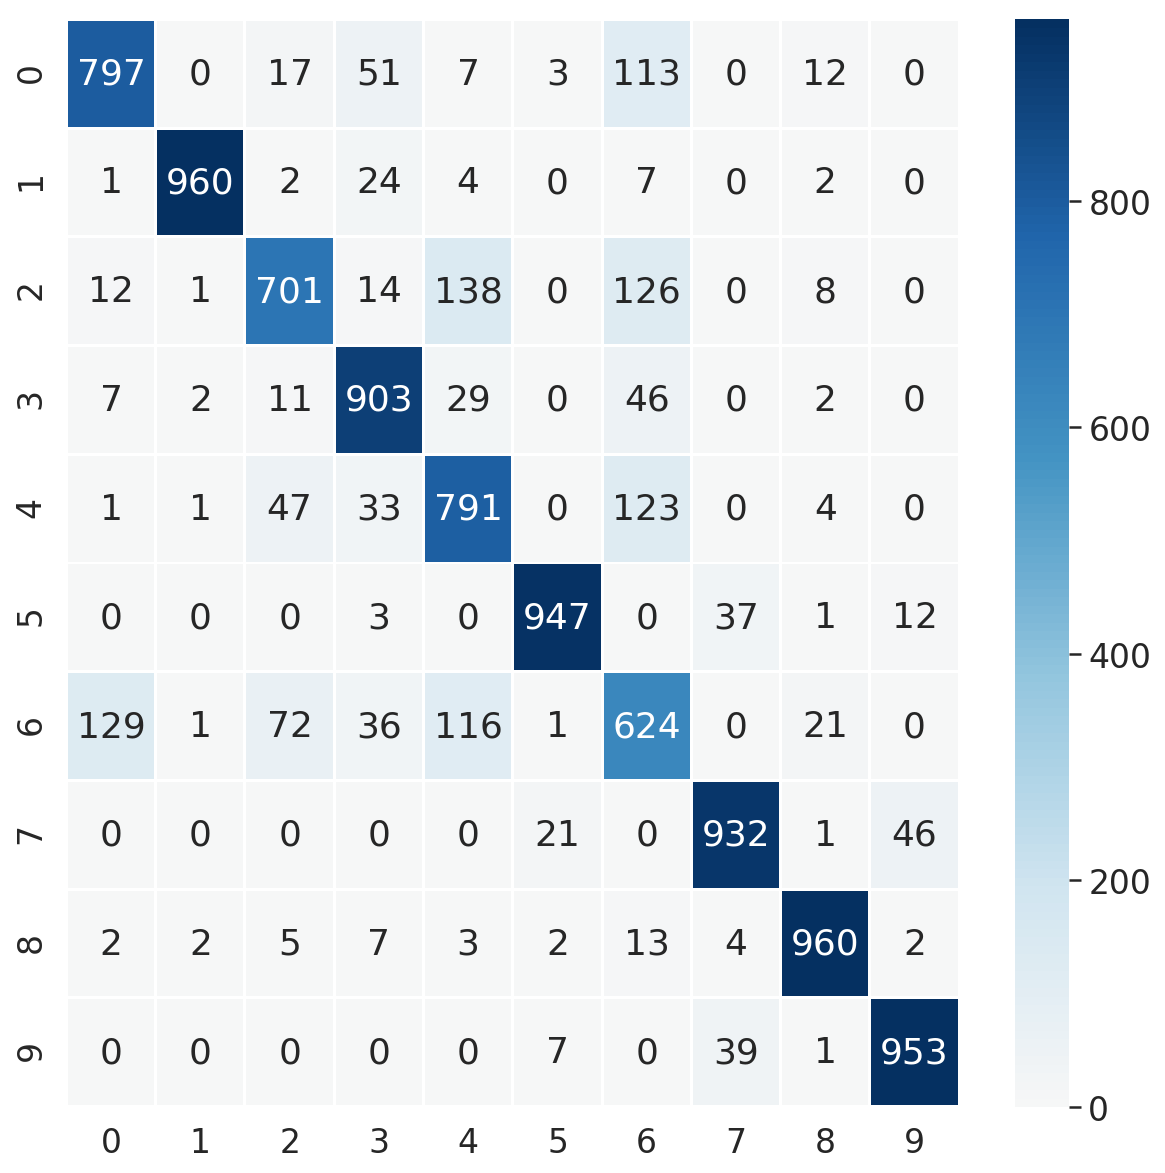

In [72]:
plt.figure(figsize=(10,10))
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, center=0, linewidth=1, fmt="d", annot=True,cmap="RdBu")

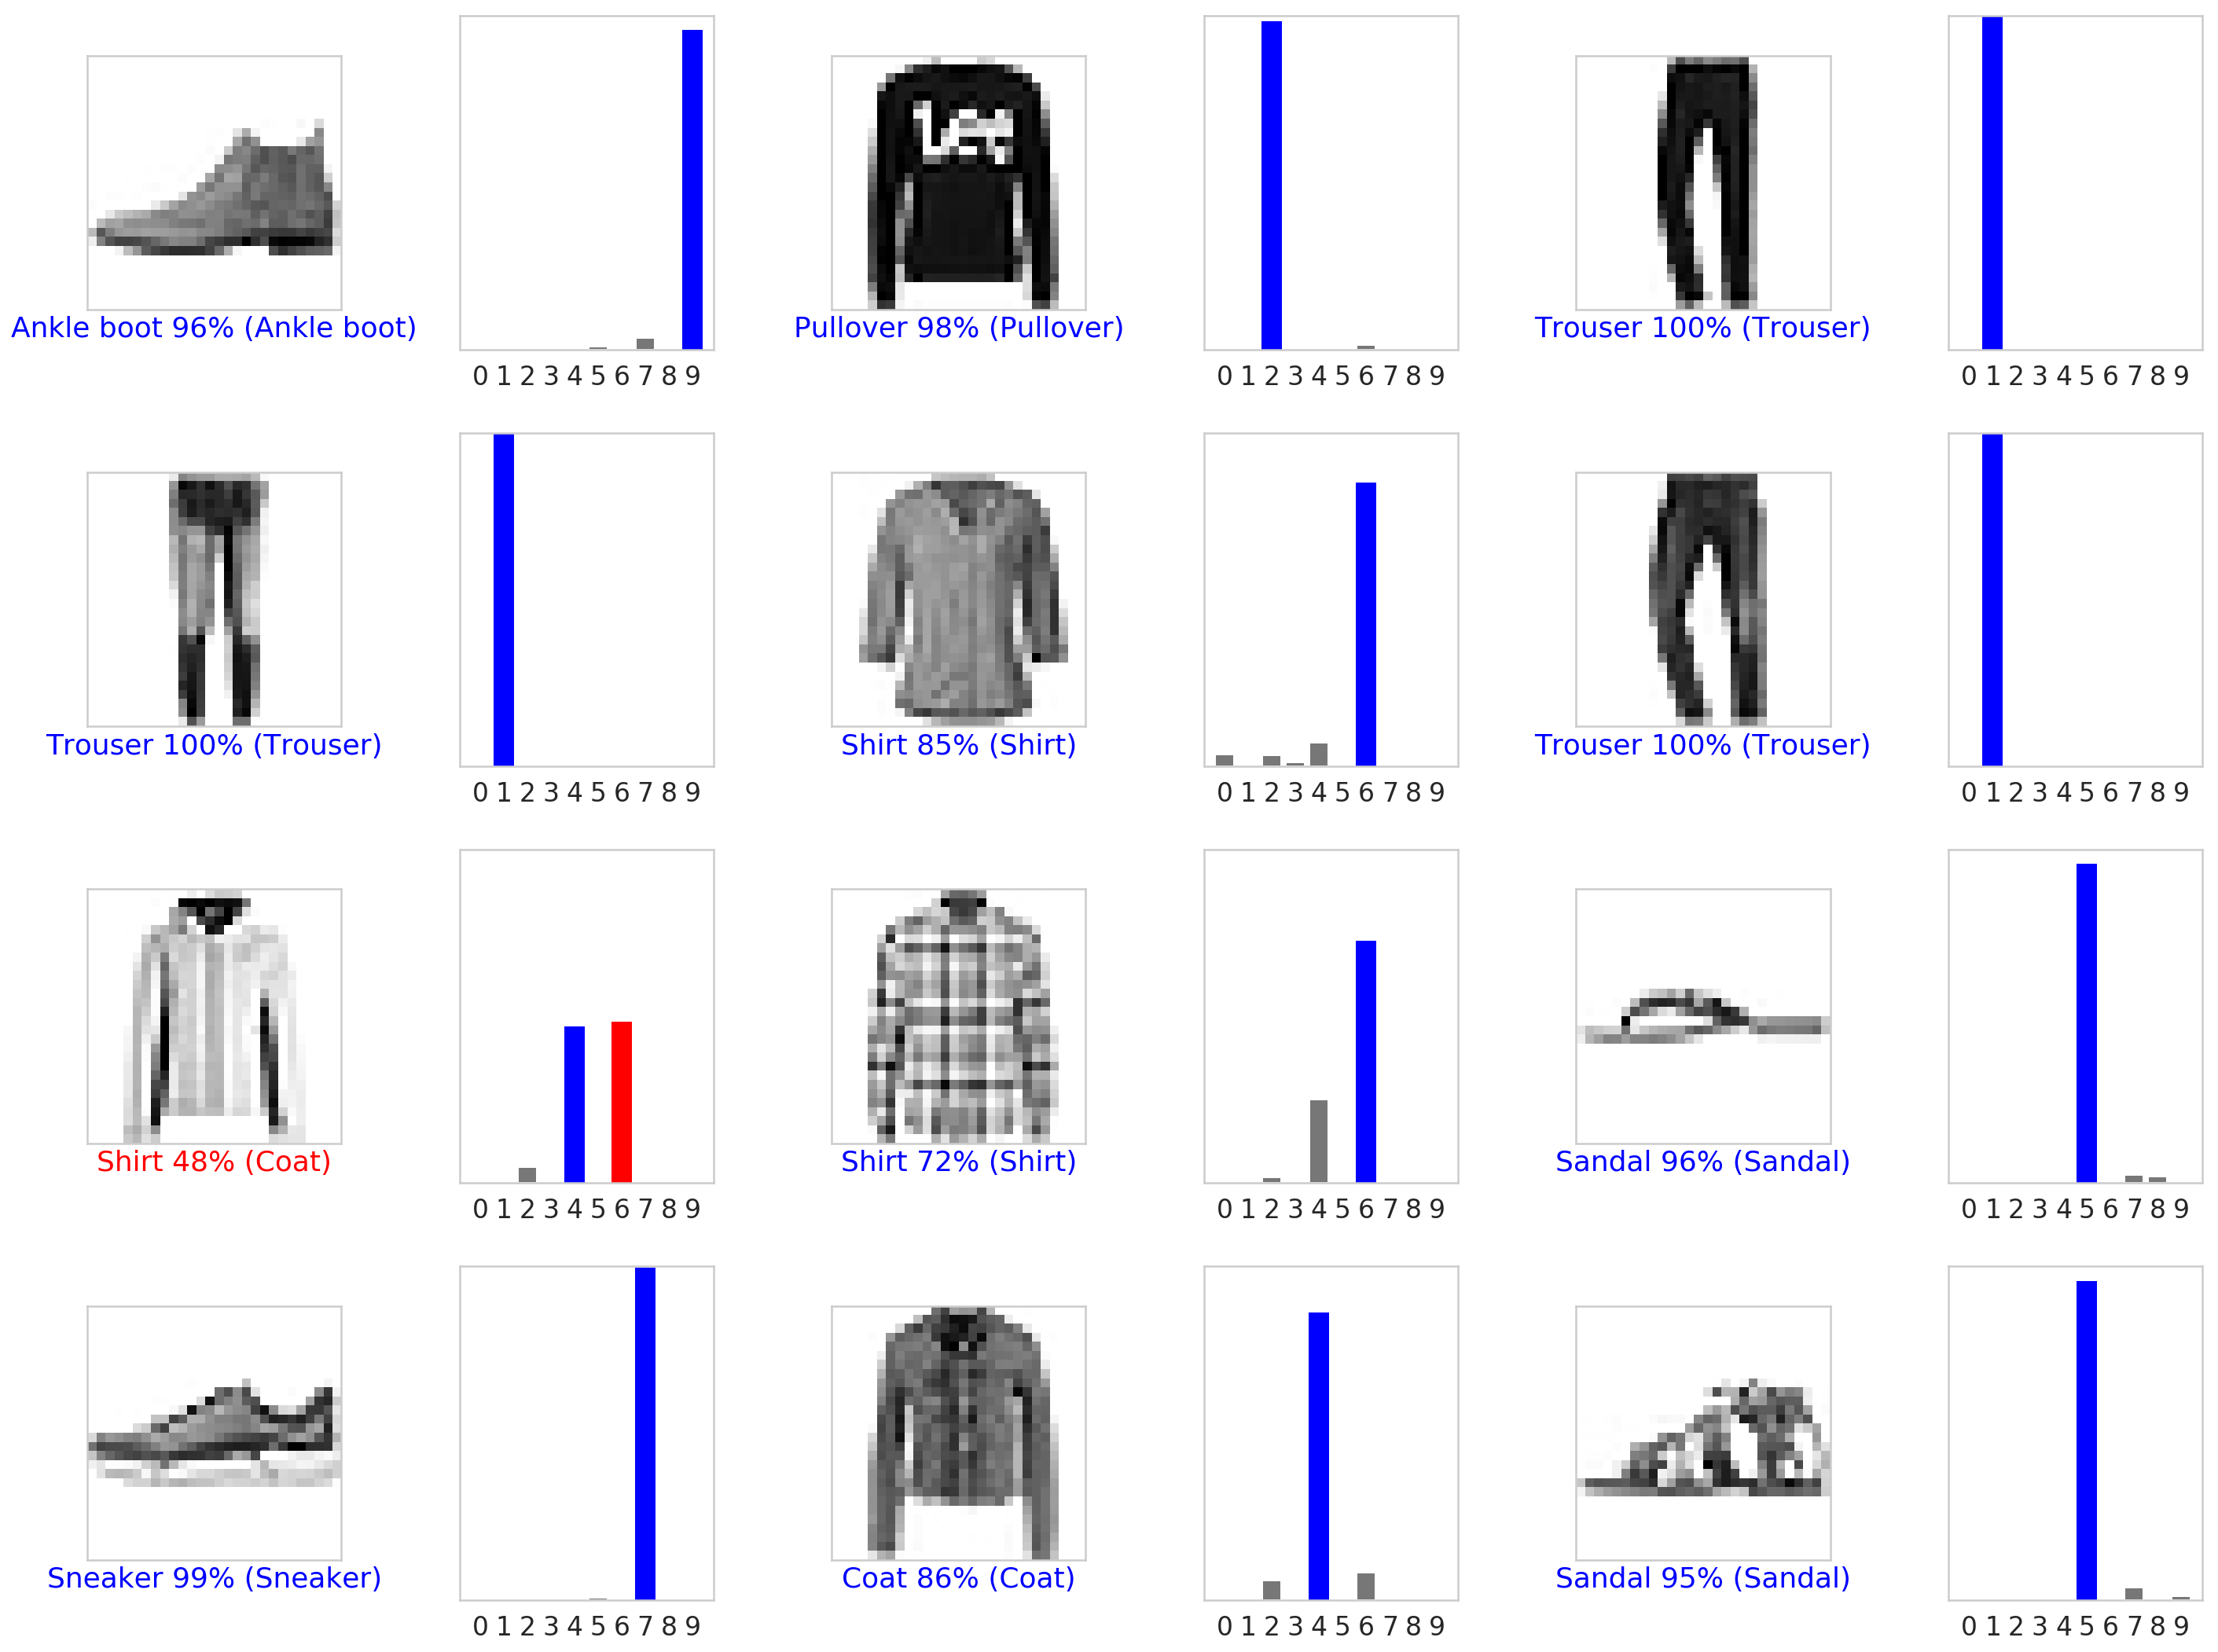

In [75]:
num_rows = 4
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(20, 15))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, pred[i], y_test, X_test.reshape(-1, 28, 28))
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, pred[i], y_test)
plt.tight_layout()
plt.show()

In [0]:
tf.keras.optimizers.Adam()